In [1]:
import os
from pathlib import Path
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from coco.coco import COCO
from itertools import chain, combinations
import glob
import cv2
from skimage.measure import label, regionprops

%matplotlib inline

In [2]:
label_dir = '/data/shared/PartImageNet/'

split = 'train'
# save_dir = os.path.join('/data/shared/PartImageNet/PartBoxSegmentations/All/', split)
# os.makedirs(save_dir, exist_ok=True)

In [3]:
CLASSES = {
    "Quadruped": 4,
    "Biped": 5,
    "Fish": 4,
    "Bird": 5,
    "Snake": 2,
    "Reptile": 4,
    "Car": 3,
    "Bicycle": 4,
    "Boat": 2,
    "Aeroplane": 5,
    "Bottle": 2,
}
CLASSES = dict(sorted(CLASSES.items()))
CLASSES

{'Aeroplane': 5,
 'Bicycle': 4,
 'Biped': 5,
 'Bird': 5,
 'Boat': 2,
 'Bottle': 2,
 'Car': 3,
 'Fish': 4,
 'Quadruped': 4,
 'Reptile': 4,
 'Snake': 2}

In [4]:
root = Path('/data/shared/PartImageNet/PartBoxSegmentations')
PATHS = {
    "train": (root / "train", root / "image_labels" / 'train.json', root / "annotations" / 'train.json'),
    "val": (root / "val", root / "image_labels" / 'val.json', root / "annotations" / 'val.json'),
    "test": (root / "test", root / "image_labels" / 'test.json', root / "annotations" / 'test.json' ),
}

os.makedirs(root / "train", exist_ok=True)
os.makedirs(root / "val", exist_ok=True)
os.makedirs(root / "test", exist_ok=True)
os.makedirs(root / "image_labels", exist_ok=True)
os.makedirs(root / "annotations", exist_ok=True)

In [5]:
categories_json = []

part_id = 0
categories_json.append(
    {'supercategory': 'background',
    'id': 0,
    'name': 'background'}
)
part_id += 1

for part_imagenet_class in CLASSES:
    for id in range(CLASSES[part_imagenet_class]):
        categories_json.append(
            {'supercategory': part_imagenet_class,
            'id': part_id,
            'name': f'{part_imagenet_class}_{part_id}'}
        )
        part_id += 1
categories_json

[{'supercategory': 'background', 'id': 0, 'name': 'background'},
 {'supercategory': 'Aeroplane', 'id': 1, 'name': 'Aeroplane_1'},
 {'supercategory': 'Aeroplane', 'id': 2, 'name': 'Aeroplane_2'},
 {'supercategory': 'Aeroplane', 'id': 3, 'name': 'Aeroplane_3'},
 {'supercategory': 'Aeroplane', 'id': 4, 'name': 'Aeroplane_4'},
 {'supercategory': 'Aeroplane', 'id': 5, 'name': 'Aeroplane_5'},
 {'supercategory': 'Bicycle', 'id': 6, 'name': 'Bicycle_6'},
 {'supercategory': 'Bicycle', 'id': 7, 'name': 'Bicycle_7'},
 {'supercategory': 'Bicycle', 'id': 8, 'name': 'Bicycle_8'},
 {'supercategory': 'Bicycle', 'id': 9, 'name': 'Bicycle_9'},
 {'supercategory': 'Biped', 'id': 10, 'name': 'Biped_10'},
 {'supercategory': 'Biped', 'id': 11, 'name': 'Biped_11'},
 {'supercategory': 'Biped', 'id': 12, 'name': 'Biped_12'},
 {'supercategory': 'Biped', 'id': 13, 'name': 'Biped_13'},
 {'supercategory': 'Biped', 'id': 14, 'name': 'Biped_14'},
 {'supercategory': 'Bird', 'id': 15, 'name': 'Bird_15'},
 {'supercatego

In [22]:
images_json = []
annotations_json = []

image_to_label = {}

global_image_id = 0
for class_label, part_imagenet_class in enumerate(CLASSES):
    print('part_imagenet_class', part_imagenet_class)
    # get filenames of all segmentation masks
    seg_label_path = os.path.join(label_dir, f'PartSegmentations/All/{split}/{part_imagenet_class}/*.tif')
    seg_filenames = glob.glob(seg_label_path)

    for filename in seg_filenames:
        # load segmentation
        im = Image.open(filename)
        width, height = im.size
        imarray = np.array(im)

        image_name = filename.split('/')[-1]
        image_id = image_name[:-4]    

        jpeg_image_name = image_id + '.JPEG'
        folder_id = image_id.split('_')[0]

        images_json.append({
            'file_name': f'{folder_id}/{jpeg_image_name}',
            'height': height,
            'width': width,
            'id': global_image_id
            })

        image_to_label[global_image_id] = class_label

        # get unique labels
        image_labels = list(np.unique(imarray))
        
        # remove background class
        if 0 in image_labels:
            image_labels.remove(0)

        assert len(image_labels) <= CLASSES[part_imagenet_class]

        for index, part_label in enumerate(image_labels):            
            # get sementation mask for object_id
            mask = (imarray == part_label) * 1
            mask = np.uint8(mask)

            lbl_0, num_regions = label(mask, return_num=True, connectivity=1) 
            props = regionprops(lbl_0)

            label_txt_lines = []
            for prop_index, prop in enumerate(props):
                min_row, min_col, max_row, max_col = prop.bbox

                bbox_width = max_col - min_col
                bbox_height = max_row - min_row

                cur_part_bbox = [min_col, min_row, bbox_width, bbox_height]

                annotations_json.append({
                    'image_id': global_image_id,
                    'bbox': cur_part_bbox,
                    'category_id': int(part_label),
                    'id': f'{image_id}_{index}_{prop_index}',
                    'area': bbox_width * bbox_height,
                    'is_crowd': 0
                })
        global_image_id += 1

part_imagenet_class Aeroplane
part_imagenet_class Bicycle
part_imagenet_class Biped
part_imagenet_class Bird
part_imagenet_class Boat
part_imagenet_class Bottle
part_imagenet_class Car
part_imagenet_class Fish
part_imagenet_class Quadruped
part_imagenet_class Reptile
part_imagenet_class Snake


In [23]:
# Serializing json
json_object = json.dumps(image_to_label, indent=4)
print(PATHS[split][1])
with open(PATHS[split][1], "w") as outfile:
    outfile.write(json_object)
    

/data/shared/PartImageNet/PartBoxSegmentations/image_labels/test.json


In [24]:
part_imagenet_bbox_json = {
    'images': images_json,
    'annotations': annotations_json,
    'categories_json': categories_json
}

# Serializing json
json_object = json.dumps(part_imagenet_bbox_json, indent=4)
 
with open(PATHS[split][2], "w") as outfile:
    outfile.write(json_object)
    

In [6]:
# Opening JSON file
with open(PATHS[split][1], 'r') as openfile:
    json_object = json.load(openfile)

In [9]:
json_object[str(8526)]

8

In [23]:
from part_model.dataloader.part_imagenet import PartImageNetBBOXDataset

img_folder, class_label_file, ann_file = PATHS[split]
print(img_folder, class_label_file, ann_file)
# dataset = PartImageNetBBOXDataset(
#         img_folder, 
#         ann_file, 
#         transforms=None, 
#         return_masks=False,
#         aux_target_hacks=aux_target_hacks_list
#     )

ModuleNotFoundError: No module named 'panoptic_parts.utils.panoptic_parts'

In [6]:
from DINO.datasets.coco import CocoDetection
# dataset = CocoDetection(img_folder, ann_file, 
#         transforms=make_coco_transforms(image_set, fix_size=args.fix_size, strong_aug=strong_aug, args=args), 
#         return_masks=False,
#         aux_target_hacks=aux_target_hacks_list,
#     )

img_folder, ann_file = PATHS[split]
print(img_folder, ann_file)
dataset = CocoDetection(img_folder, ann_file, 
        transforms=None, 
        return_masks=False,
        aux_target_hacks=aux_target_hacks_list
    )

/home/nab_126/miniconda3/envs/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/shared/PartImageNet/PartBoxSegmentations/train /data/shared/PartImageNet/PartBoxSegmentations/annotations/train.json
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [7]:
for obj in json_object['annotations']:
    if obj['image_id'] == 0:
        # print(obj)
        print(obj['bbox'])

[28, 271, 178, 80]
[205, 248, 525, 101]
[301, 190, 151, 81]
[633, 268, 134, 22]
[248, 325, 368, 70]
[585, 151, 167, 106]


In [8]:
image, targets = dataset[0]
image.size
targets


{'boxes': tensor([[ 28., 271., 206., 351.],
         [205., 248., 730., 349.],
         [301., 190., 452., 271.],
         [633., 268., 767., 290.],
         [248., 325., 616., 395.],
         [585., 151., 752., 257.]]),
 'labels': tensor([1, 2, 4, 4, 4, 5]),
 'image_id': tensor([0]),
 'area': tensor([14240, 53025, 12231,  2948, 25760, 17702]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([534, 800]),
 'size': tensor([534, 800])}

In [15]:
class Rectangle:
    def __init__(self, length, width):
        self.length = length
        self.width = width

    def area(self):
        return self.length * self.width

    def perimeter(self):
        return 2 * self.length + 2 * self.width

# Here we declare that the Square class inherits from the Rectangle class
class Square(Rectangle):
    def __init__(self, length):
        super().__init__(length, length)

    def area(self):
        a = super().area()
        print('a', a)
        return a + 4

s = Square(4)
s.area()

a 16


20

In [15]:
from pycocotools.coco import COCO

coco = COCO(ann_file)
target = coco.loadAnns(coco.getAnnIds(0))
print(len(target))
for x in target:
    print(x['bbox'])

# ids = list(sorted(coco.imgs.keys()))


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
6
[28, 271, 178, 80]
[205, 248, 525, 101]
[248, 325, 368, 70]
[248, 325, 368, 70]
[248, 325, 368, 70]
[585, 151, 167, 106]


In [62]:
id = ids[0]
id
coco.loadImgs(id)

KeyError: 'n'

In [28]:
for class_label, part_imagenet_class in enumerate(CLASSES):
    print('part_imagenet_class', part_imagenet_class)
    # get filenames of all segmentation masks
    seg_label_path = os.path.join(label_dir, f'PartSegmentations/All/train/{part_imagenet_class}/*.tif')
    seg_filenames = glob.glob(seg_label_path)

    # directory to save new labels
    txt_dir = os.path.join(save_dir, part_imagenet_class)
    os.makedirs(txt_dir, exist_ok=True)

    for filename in seg_filenames:
        # load segmentation
        im = Image.open(filename)
        imarray = np.array(im)
        image_shape = imarray.shape

        image_name = filename.split('/')[-1][:-4]

        # get unique labels
        image_labels = list(np.unique(imarray))
        # remove background class
        image_labels.remove(0)

        assert len(image_labels) <= CLASSES[part_imagenet_class]

        for index, part_label in enumerate(image_labels):
            # get sementation mask for object_id
            mask = (imarray == part_label) * 1
            mask = np.uint8(mask)
            mask_copy = mask.copy()

            lbl_0, num_regions = label(mask, return_num=True, connectivity=1) 
            # print('object_id', object_id, 'num_regions', num_regions)
            props = regionprops(lbl_0)

            label_txt_lines = []
            for prop in props:
                cv2.rectangle(mask_copy, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (1, 0, 0), 2)
                min_row, min_col, max_row, max_col = prop.bbox

                cx = (min_col+max_col)/2
                cy = (min_row+max_row)/2
                width = max_col - min_col
                height = max_row - min_row

                cx_normalized = cx/image_shape[1]
                cy_normalized = cy/image_shape[0]
                width_normalized = width/image_shape[1]
                height_normalized = height/image_shape[0]

                assert(all([0 <= m <= 1 for m in [cx_normalized, cy_normalized, width_normalized, height_normalized]]))
                # label is (class_label, part_label, cx_normalized, cy_normalized, width_normalized, height_normalized)
                current_label = f'{class_label} {part_label} {cx_normalized} {cy_normalized} {width_normalized} {height_normalized}'
                label_txt_lines.append(current_label)
            
        txt_filename = image_name + '.txt'
        
        txt_save_path = os.path.join(txt_dir, txt_filename)
        # print('txt_save_path', txt_save_path)
        
        with open(txt_save_path, 'w') as f:
            for line in label_txt_lines:
                f.write(line)
                f.write('\n')

part_imagenet_class Aeroplane
part_imagenet_class Bicycle
part_imagenet_class Biped
part_imagenet_class Bird
part_imagenet_class Boat
part_imagenet_class Bottle
part_imagenet_class Car
part_imagenet_class Fish
part_imagenet_class Quadruped
part_imagenet_class Reptile
part_imagenet_class Snake


ValueError: list.remove(x): x not in list

In [ ]:
with open(os.path.join(txt_dir, 'n04552348_10818.txt')) as f:
    lines = f.readlines()
lines


In [ ]:
# needs to have images, only needs filename
# categories
# supercategory
# annotations
import json
 
# Data to be written
dictionary = {
    "name": "sathiyajith",
    "rollno": 56,
    "cgpa": 8.6,
    "phonenumber": "9976770500"
}
 
# Serializing json
json_object = json.dumps(dictionary, indent=4)
 
# Writing to sample.json
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
import torch.utils.data as data

In [ ]:
class PartImageNetBBOXDataset(data.Dataset):
    def __init__(
        self,
        root,
        bbox_path,
        split="train",
        transform=None,
        use_label=False,
        seg_type=None,
        seg_fraction=1.0,
        seed=0,
    ):
        """Load our processed Part-ImageNet dataset

        Args:
            root (str): Path to root directory
            split (str, optional): Data split to load. Defaults to 'train'.
            transform (optional): Transformations to apply to the images (and
                the segmentation masks if applicable). Defaults to None.
            use_label (bool, optional): Whether to yield class label. Defaults to False.
            seg_type (str, optional): Specify types of segmentation to load
                ('part', 'object', or None). Defaults to 'part'.
            seg_fraction (float, optional): Fraction of segmentation mask to
                provide. The dropped masks are set to all -1. Defaults to 1.
            seed (int, optional): Random seed. Defaults to 0.
        """
        self.root = root
        self.split = split
        self.bbox_path = os.path.join(bbox_path, split)
        self.transform = transform
        self.use_label = use_label

        self.classes = self._list_classes()
        self.num_classes = len(self.classes)
        self.num_seg_labels = sum([CLASSES[c] for c in self.classes])

        self.images, self.labels, self.masks = self._get_data()
        idx = np.arange(len(self.images))
        with np_temp_seed(seed):
            np.random.shuffle(idx)
        self.seg_drop_idx = idx[: int((1 - seg_fraction) * len(self.images))]

        # Create matrix that maps part segmentation to object segmentation
        part_to_object = [0]
        self.part_to_class = [[0] * (self.num_classes + 1)]
        self.part_to_class[0][0] = 1
        for i, label in enumerate(self.classes):
            part_to_object.extend([i + 1] * CLASSES[label])
            base = [0] * (self.num_classes + 1)
            base[i + 1] = 1
            self.part_to_class.extend([base] * CLASSES[label])
        self.part_to_object = torch.tensor(part_to_object, dtype=torch.long)

    def __getitem__(self, index):
        _img = Image.open(self.images[index]).convert("RGB")
        _target = Image.open(self.masks[index])

        if self.transform is not None:
            _img, _target = self.transform(_img, _target)

        if self.seg_type is not None:
            if self.seg_type == "object":
                _target = self.part_to_object[_target]
            elif self.seg_type == "fg":
                _target = (_target > 0).long()

            if index in self.seg_drop_idx:
                # Drop segmentation mask by setting all pixels to -1 to ignore
                # later at loss computation
                _target.mul_(0).add_(-1)

            if self.use_label:
                _label = self.labels[index]
                return _img, _target, _label
            return _img, _target

        if self.use_label:
            _label = self.labels[index]
            return _img, _label
        return _img

    def _get_data(self):
        images, labels, bboxes = [], [], []
        for l, label in enumerate(self.classes):
            img_path = os.path.join(self.root, "JPEGImages")
            part_path = os.path.join(self.path, label)
            # Read file names
            with open(f"{self.path}/{label}.txt", "r") as fns:
                filenames = sorted([f.strip() for f in fns.readlines()])
            images.extend([f"{img_path}/{f}.JPEG" for f in filenames])
            bboxes.extend(
                [f'{part_path}/{f.split("/")[1]}.tif' for f in filenames]
            )
            labels.extend([l] * len(filenames))
        labels = torch.tensor(labels, dtype=torch.long)
        return images, labels, bboxes

    def _list_classes(self):
        dirs = os.listdir(self.path)
        dirs = [d for d in dirs if os.path.isdir(os.path.join(self.path, d))]
        return sorted(dirs)

    def __len__(self):
        return len(self.images)

In [7]:
im = Image.open('/data/shared/PartImageNet/JPEGImages/n02423022/n02423022_34258.JPEG')
imarray = np.array(im)
plt.imshow(imarray)

In [8]:
image_index = 11
# im = Image.open('/data/shared/PartImageNet/PartSegmentations/All/train/Quadruped/n02423022_34258.tif')
im = Image.open(files[image_index])
imarray = np.array(im)
image_labels = list(np.unique(imarray))
print('image_labels', image_labels)
image_labels.remove(0)
print('image_labels', image_labels)
print()
plt.imshow(imarray)


image_labels [0, 31, 32, 33, 34]
image_labels [31, 32, 33, 34]



In [9]:
files[image_index]

'/data/shared/PartImageNet/PartSegmentations/All/train/Quadruped/n02120079_4625.tif'

In [10]:
filename = files[image_index]
filename
image_name = filename.split('/')[-1][:-4]
image_filename = f"/data/shared/PartImageNet/JPEGImages/{image_name.split('_')[0]}/{image_name}.jpg"
image_filename

'/data/shared/PartImageNet/JPEGImages/n02120079/n02120079_4625.jpg'

In [13]:
num_examples = 20

fig, axs = plt.subplots(num_examples, len(image_labels)+2, figsize = (20, 6*num_examples), squeeze=False)

for row in range(num_examples):
    # image_index = 11
    image_index = row

    im = Image.open('/data/shared/PartImageNet/JPEGImages/n02423022/n02423022_34258.JPEG')
    filename = files[image_index]

    filename = files[image_index]
    
    image_name = filename.split('/')[-1][:-4]
    image_filename = f"/data/shared/PartImageNet/JPEGImages/{image_name.split('_')[0]}/{image_name}.JPEG"

    im = Image.open(image_filename)
    axs[row][0].imshow(im)
    axs[row][0].set_title('Original Image')

    im = Image.open(filename)
    imarray = np.array(im)
    image_labels = list(np.unique(imarray))
    # print('image_labels', image_labels)
    image_labels.remove(0)
    # print('image_labels', image_labels)

    axs[row][1].imshow(imarray, cmap='gray')
    axs[row][1].set_title('Original Segmentation Mask')

    for index, id in enumerate(image_labels):
        mask = (imarray == id) * 1
        mask = np.uint8(mask)

        mask_copy = mask.copy()


        # erosion
        kernel = np.ones((5, 5), np.uint8)
        mask_eroded = cv2.erode(mask, kernel, iterations=1)



        lbl_0, num_regions = label(mask_eroded, return_num=True, connectivity=1) 
        # print('id', id, 'num_regions', num_regions)
        props = regionprops(lbl_0)
        
        for prop in props:
            # print('Found bbox', prop.bbox)
            cv2.rectangle(mask_copy, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (1, 0, 0), 2)

        axs[row][index+2].imshow(mask_copy, cmap='gray')
        axs[row][index+2].set_title(f'bbox for obj id {id}')
plt.savefig('bbox_conversion_examples.jpg')
plt.show()


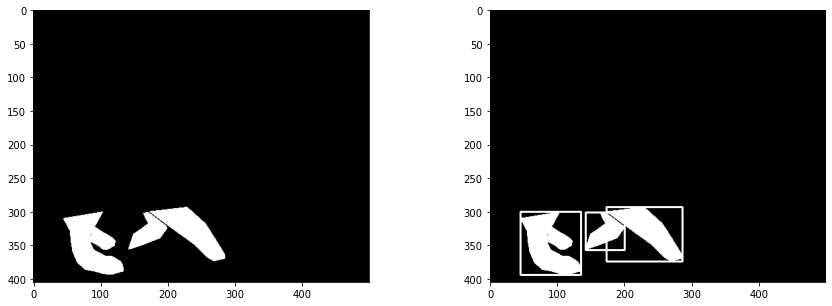

In [207]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5), squeeze=False)
axs[0][0].imshow(mask, cmap='gray')
axs[0][1].imshow(img_1, cmap='gray')

In [173]:
# Find Canny edges
edged = cv2.Canny(mask, 0, 5)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours is: " + str(len(contours)))

Number of Contours is: 5


mask sum() 1078


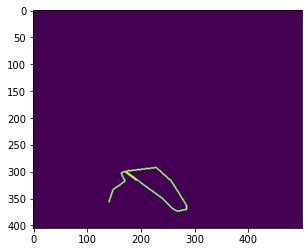

In [175]:

mask_ = np.zeros_like(mask)

cv2.drawContours(mask_, contours[-1], -1, 1, 2)
print('mask sum()', mask_.sum())
plt.imshow(mask_)

In [136]:
mask_.sum()

1085

Found bbox (292, 141, 376, 288)
Found bbox (295, 144, 373, 285)
Found bbox (299, 44, 396, 137)
Found bbox (302, 47, 393, 134)


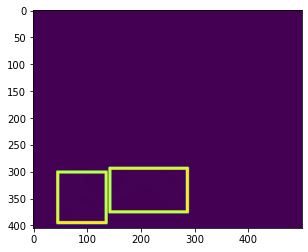

In [182]:
plt.imshow(img_1)

In [23]:
    # for k in classes:
    #     num_parts += CLASSES[k]
    #     all_part_ids.extend(coco.getCatIds(supNms=k))
coco = COCO('/data/shared/PartImageNet/train.json')
coco.getCatIds(supNms='Quadruped')

loading annotations into memory...
Done (t=1.71s)
creating index...
index created!


[0, 1, 2, 3]

In [30]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    
label = 'Quadruped'

print(f"  ==> label: {label}")

# Get id's of the desired class
cat_ids = coco.getCatIds(supNms=label)



# Iterate through all combinations of parts
img_ids = []
for ids in powerset(cat_ids):
    if len(ids) == 0:
        continue

    print(ids)
    qqq
    # Select only images from this class
    img_ids.extend(coco.getImgIds(catIds=ids))
img_ids = set(img_ids)

imgs = coco.loadImgs(img_ids)
seg_masks, img_paths = [], []
for i, img_id in tqdm(enumerate(img_ids)):
    img = imgs[i]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    if img["file_name"].split(".")[0] not in all_image_names:
        print(f'{img["file_name"].split(".")[0]} file missing!')
        continue
    img_path = f'{img["file_name"].split("_")[0]}/{img["file_name"].split(".")[0]}'
    img_paths.append(img_path)

    # Turn annotation to mask
    seg_mask = np.zeros((img["height"], img["width"]), dtype=np.int8)
    for ann in anns:
        if ann["area"] == 0:
            continue
        part_mask = coco.annToMask(ann)
        seg_label = all_part_ids.index(ann["category_id"]) + 1
        if use_box_seg:
            part_mask = _get_box_from_bin_mask(part_mask)
        seg_mask = part_mask * seg_label + (1 - part_mask) * seg_mask
    assert seg_mask.max() <= num_parts
    assert seg_mask.min() >= 0
    seg_masks.append(seg_mask)

data_dict["seg_masks"].extend(seg_masks)
data_dict["img_paths"].extend(img_paths)
data_dict["labels"].extend(
    [list(CLASSES.keys()).index(label)] * len(seg_masks)
)



  ==> label: Quadruped
(0,)


NameError: name 'qqq' is not defined

In [31]:
coco.getImgIds(catIds=ids)

[10886,
 10887,
 10888,
 10889,
 10890,
 10891,
 10892,
 10893,
 10894,
 10895,
 10896,
 10897,
 10898,
 10899,
 10900,
 10901,
 10902,
 10903,
 10904,
 10905,
 10906,
 10907,
 10908,
 10909,
 10910,
 10911,
 10912,
 10913,
 10914,
 10915,
 10916,
 10917,
 10918,
 10919,
 10920,
 10921,
 10922,
 10923,
 10924,
 10925,
 10926,
 10927,
 10928,
 10929,
 10930,
 10931,
 10932,
 10933,
 10934,
 10935,
 10936,
 10937,
 10938,
 10939,
 10940,
 10941,
 10942,
 10943,
 10944,
 10945,
 10946,
 10947,
 10948,
 10949,
 10950,
 10951,
 10952,
 10953,
 10954,
 10955,
 10956,
 10957,
 10958,
 10959,
 10960,
 10961,
 10962,
 10963,
 10964,
 10965,
 10966,
 10967,
 10968,
 10969,
 10970,
 10971,
 10972,
 10973,
 10974,
 10975,
 10976,
 10977,
 10978,
 10979,
 10980,
 10981,
 10982,
 10983,
 10984,
 10985,
 10986,
 10987,
 10988,
 10989,
 10990,
 10991,
 10992,
 10993,
 10994,
 10995,
 10996,
 10997,
 10998,
 10999,
 11000,
 11001,
 11002,
 11003,
 11004,
 11005,
 11006,
 11007,
 11008,
 11009,
 11010,


In [24]:
import json


In [25]:
f = open('/data/shared/PartImageNet/train.json')
data = json.load(f)

In [26]:
data

{'info': 'Byte2COCO',
 'license': ['none'],
 'images': [{'height': 375,
   'width': 500,
   'id': 0,
   'file_name': 'n04252225_8354.JPEG'},
  {'height': 357, 'width': 500, 'id': 1, 'file_name': 'n04146614_18045.JPEG'},
  {'height': 375, 'width': 500, 'id': 2, 'file_name': 'n04465501_3338.JPEG'},
  {'height': 349, 'width': 600, 'id': 3, 'file_name': 'n03100240_12854.JPEG'},
  {'height': 500, 'width': 375, 'id': 4, 'file_name': 'n02701002_12308.JPEG'},
  {'height': 375, 'width': 500, 'id': 5, 'file_name': 'n04146614_1305.JPEG'},
  {'height': 588, 'width': 875, 'id': 6, 'file_name': 'n02701002_16707.JPEG'},
  {'height': 345, 'width': 460, 'id': 7, 'file_name': 'n03670208_38480.JPEG'},
  {'height': 437, 'width': 700, 'id': 8, 'file_name': 'n03770679_8222.JPEG'},
  {'height': 332, 'width': 500, 'id': 9, 'file_name': 'n03770679_24880.JPEG'},
  {'height': 375, 'width': 500, 'id': 10, 'file_name': 'n03977966_45791.JPEG'},
  {'height': 375, 'width': 500, 'id': 11, 'file_name': 'n03770679_3699.